In [618]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM, MLSolver

In [619]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools
using JLD2, Geppetto

In [620]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Steven's layer model

## Basic no space solve

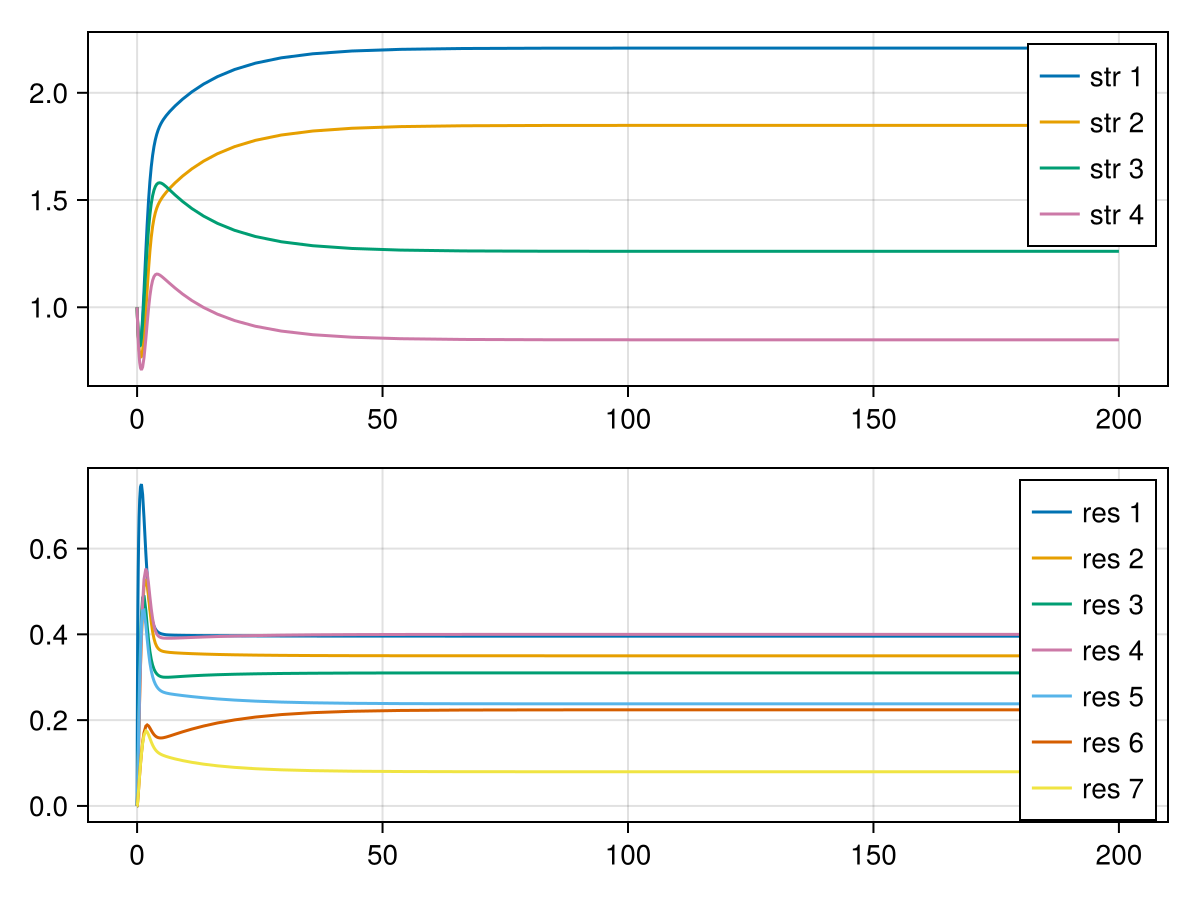

11-element Vector{Float64}:
 2.2083698366382762
 1.8481259347079133
 1.260843689623152
 0.8482064385762076
 0.3958485996019843
 0.3500000044167428
 0.31020497783099676
 0.3999999912804951
 0.23798620224184044
 0.22402758271570503
 0.07959005177302415

In [621]:
l = fill(0., 4, 7)
c = fill(0., 4, 7)
c[:, 1] .= 2. # they all eat glucose
l[:, 1] .= 1. # and they leak all of it

D = fill(0., 4, 7, 7)
# 1-2 cross feeding
D[1, 2, 1] = 0.8
c[2, 2] = 2.
D[2, 3, 1] = 1.
c[1, 3] = 2.

# 3-4 cross feeding
D[3, 4, 1] = 0.8
c[4, 4] = 2.
D[4, 5, 1] = 1.
c[3, 5] = 2.

# 1-3 cross feeding
D[1, 6, 1] = 0.2
c[3, 6] = 1.
D[3, 7, 1] = 0.2
c[1, 7] = 1.

# display(l)
# display(c)
# display(D)
p = make_mmicrm_smart(4, 7, 200;
    D, l, c,
    K=[5., 0., 0., 0., 0., 0., 0.],
    r=fill(0.3, 7),
    m=[0.7, 0.7, 0.7, 0.8],
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)
# check_mmicrmparams(p.p)

#### Steady state solving

In [622]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


68-element Vector{Vector{Pair{Symbolics.Num, Complex{Symbolics.Num}}}}:
 [u1 => -0.2505237669841929, u2 => 0.0, u3 => -0.0027752475439124136, u4 => 0.023166815555324842, u5 => -31.198444970282257, u6 => 41.685077109355504, u7 => 0.0, u8 => 0.4, u9 => -4.909287386678131, u10 => 10.518574773356264, u11 => 0.7]
 [u1 => -0.0025988975085542093, u2 => 0.023669403378296625, u3 => -0.25658264915542583, u4 => 0.0, u5 => -29.235613843145874, u6 => 0.35, u7 => -4.694602179828955, u8 => 40.00720666431685, u9 => 0.0, u10 => 0.7, u11 => 10.08920435965791]
 [u1 => -0.15, u2 => 0.0, u3 => -0.15, u4 => 0.0, u5 => -16.666666666666668, u6 => 13.333333333333334, u7 => -2.9833333333333334, u8 => 13.333333333333334, u9 => -2.9833333333333334, u10 => 6.666666666666667, u11 => 6.666666666666667]
 [u1 => 0.0, u2 => 0.0, u3 => -0.3, u4 => 0.0, u5 => -16.666666666666668, u6 => 0.0, u7 => 0.0, u8 => 26.666666666666668, u9 => 0.0, u10 => 0.7, u11 => 6.666666666666667]
 [u1 => 0.0, u2 => -0.15, u3 => -0.15, u4 => 0

In [623]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[2.208353075114234, 1.8481092669527548, 1.2608601828331198, 0.8482215478479703, 0.3958487148569626, 0.3500003771261619, 0.3102044662287901, 0.39999925514601414, 0.23798777474094734, 0.2240233565475858, 0.07959170230593754]

## Linear stability analysis

In [755]:
ks = LinRange(0., 20., 1000)
Ds = [fill(1e-4, 4); 0.; fill(1., 4); fill(10., 2)]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[1.641926885139755e-8, 1.632539384906233e-8, -1.613957340185581e-8, -1.4791880387786818e-8, -1.1432010893486222e-10, -3.675164617078508e-10, 5.01135799524377e-10, 7.136835566967648e-10, -1.5330030578297738e-9, 4.11127287769375e-9, -1.6222030663204379e-9]

maximum(real(lambdas)) = 0.027674505342936712


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.216170
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.216170
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.222814
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.222814
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.975326
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.975326
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.087381
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.087381


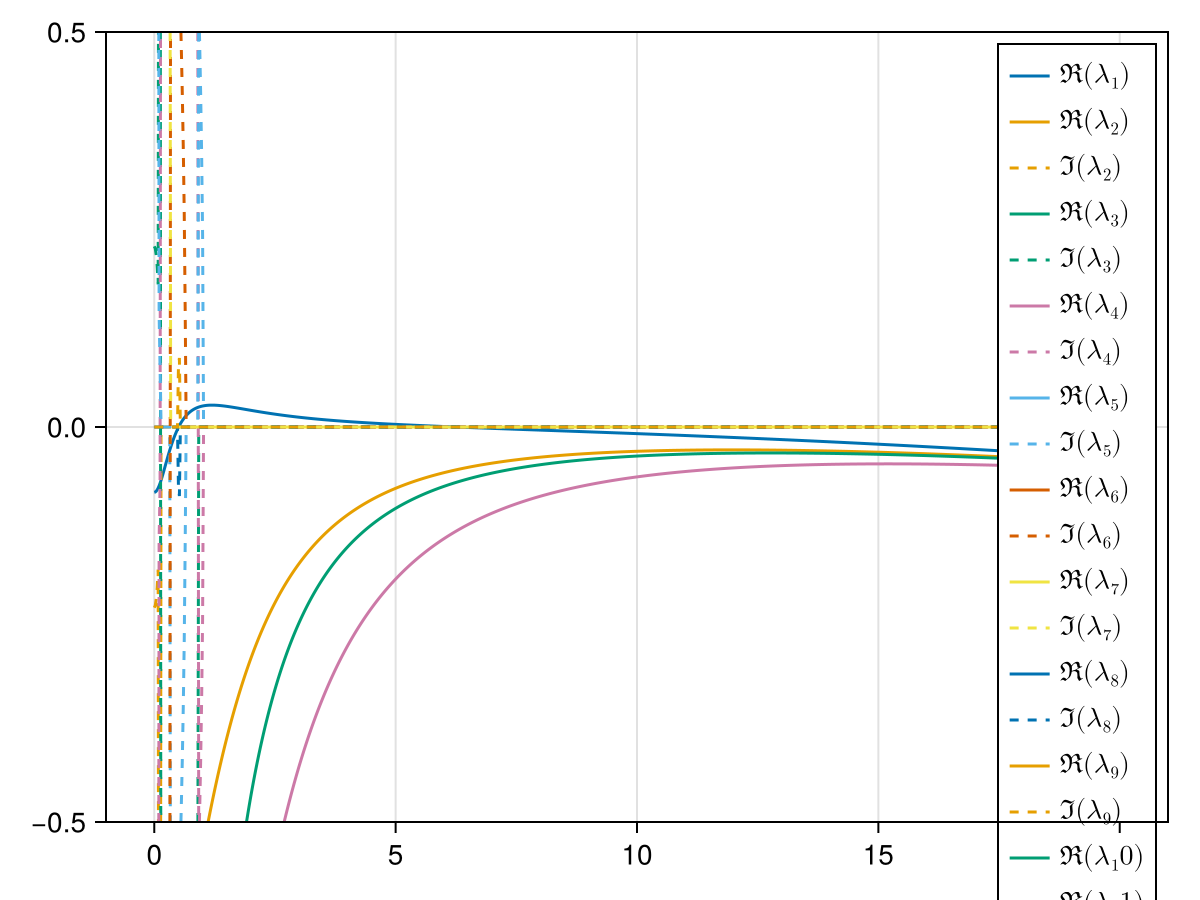

In [756]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [757]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(61, 1.2012012012012012)

In [758]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

11-element Vector{Float64}:
  0.5210292813671491
  0.45498647382141316
 -0.5827278707110091
 -0.42592717322585544
  0.0020413074121597894
  0.003424325861421893
  0.007192953427930313
 -0.006984613110809862
 -0.013135328539529997
  0.013413556666658366
 -0.007822512439298695

## Spatial stuff - 1D!

In [765]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.04, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((11, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.04]))

#### Direct solver

In [775]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

 11.223534 seconds (1.59 M allocations: 6.676 GiB, 22.22% gc time)
Success
nf is 12154
solution has 722 saved states
max resid is 1.43356e-08


┌ Warning: reaching negative values, minimum is -1.79439e-05
└ @ SSMCMain.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


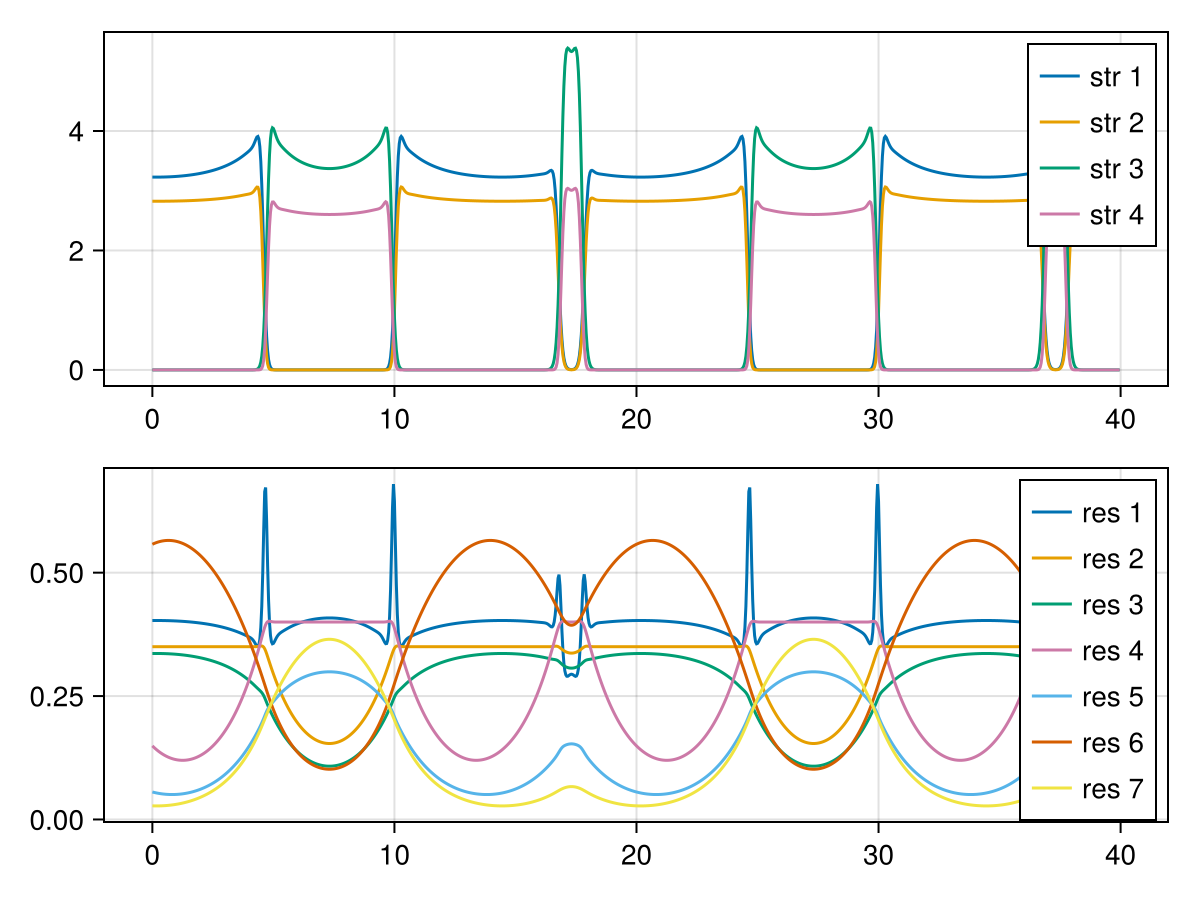

In [767]:
faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])
#display(GLMakie.Screen(), faa.figure)

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

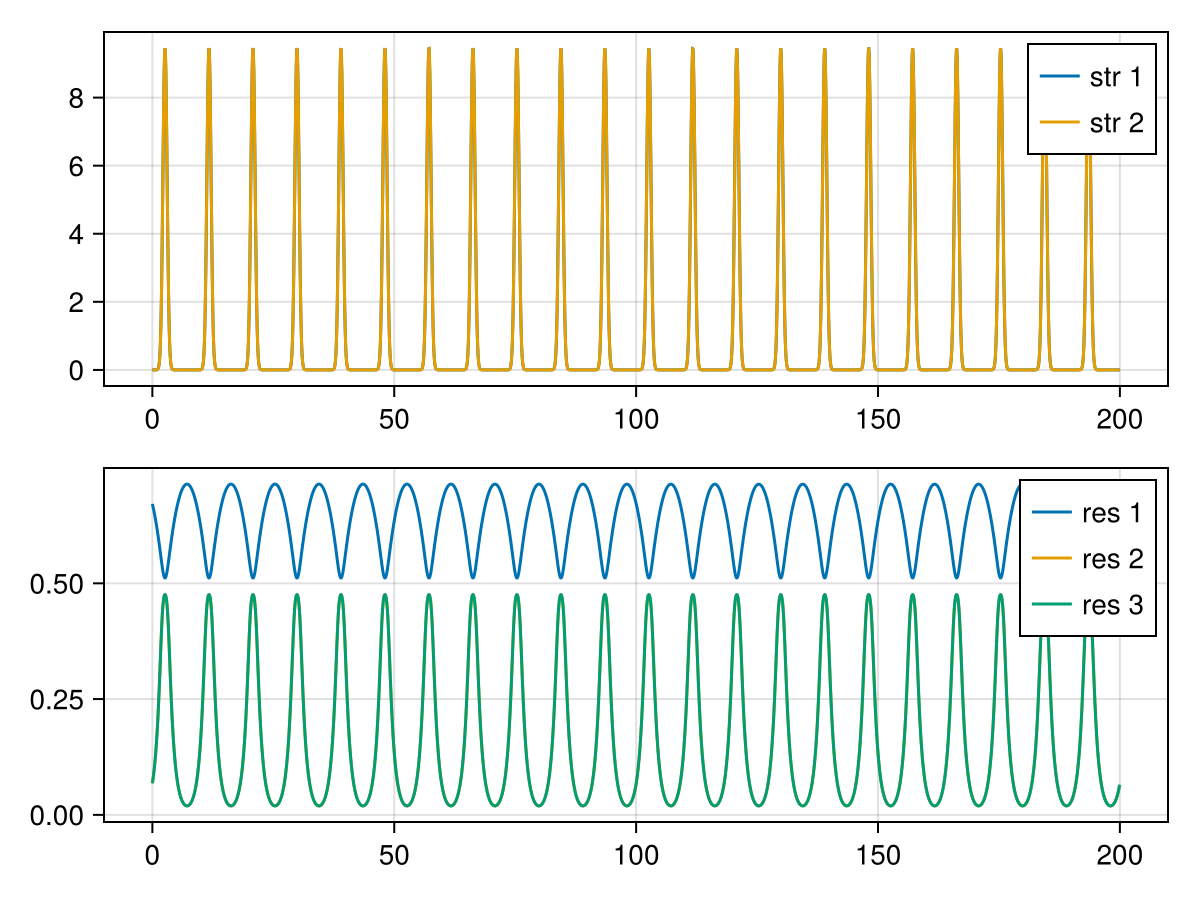

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [462]:
ssize = (70,70)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 1e-6)
space = make_cartesianspace_smart(length(ssize); dx=0.2, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((11, 70, 70), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.2, 0.2]))

#### Direct solver

In [777]:
@time sps = solve(sp, TRBDF2(); maxiters=1000)
print_spatial_solution_stats(sps)

 11.356461 seconds (1.84 M allocations: 6.404 GiB, 20.52% gc time)
MaxIters
nf is 9881
solution has 860 saved states
max resid is 0.000637347


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/elLNZ/src/integrator_interface.jl:589
┌ Warning: reaching negative values, minimum is -8.18884e-08
└ @ SSMCMain.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


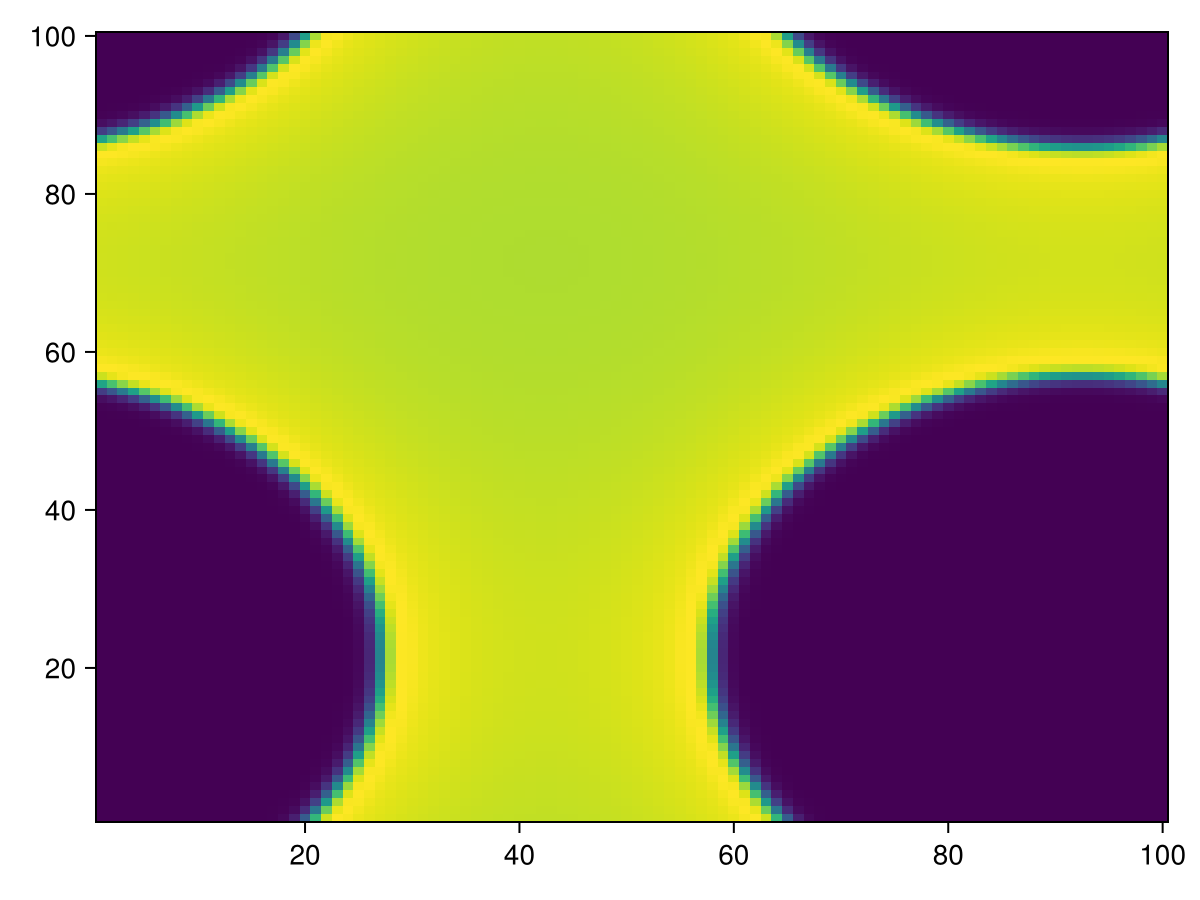

In [544]:
heatmap(sps(sps.t[end])[1,:,:])

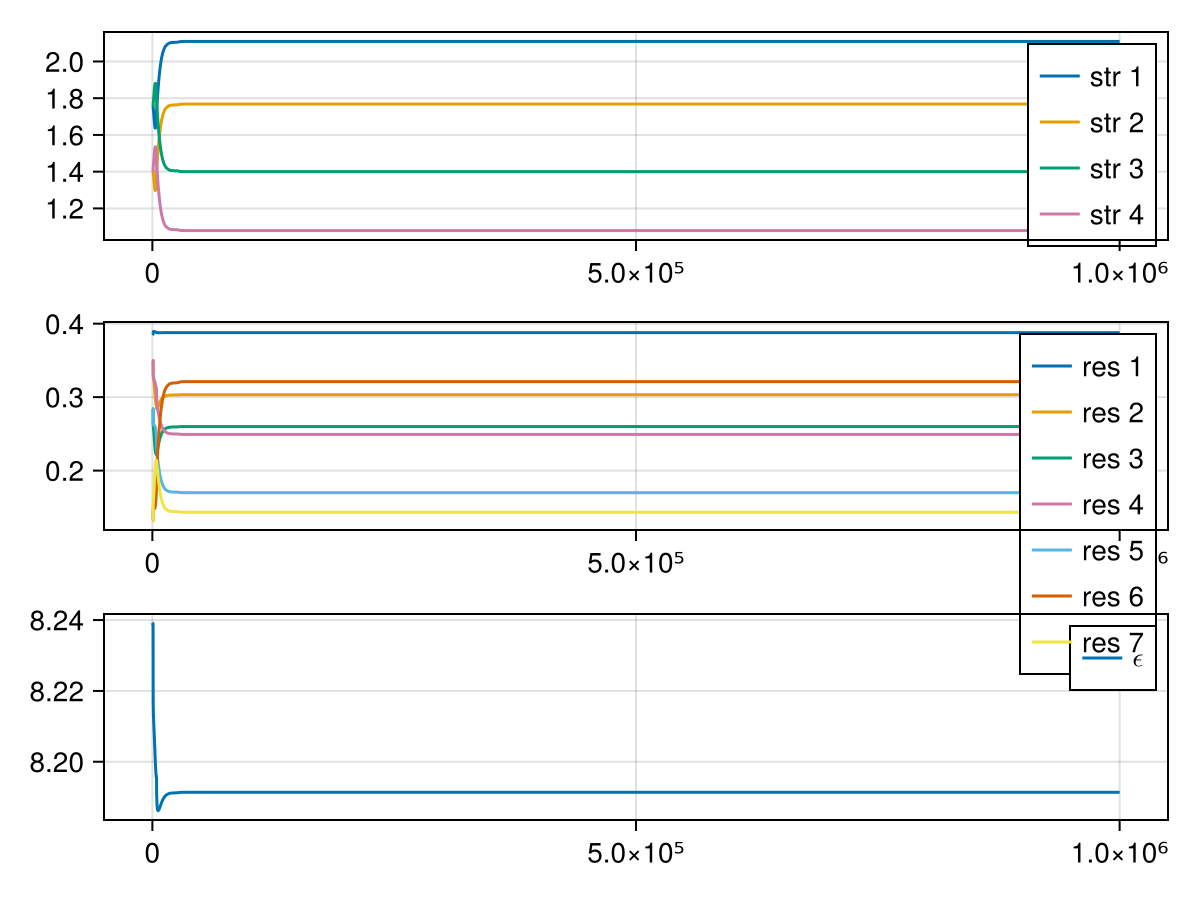

In [545]:
plot_smmicrm_sol_avgs(sps; plote=true)

In [466]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  6363
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    280
Number of linear solves:                           4976
Number of Jacobians created:                       57
Number of nonlinear solver iterations:             3984
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          438
Number of rejected steps:                          59

#### Loading/saving solutions

In [468]:
save_object(datadir("layers47", randname()*".jld2"), sps)

In [780]:
#sps = load_object("../data/layers47/sl2d_1.jld2");
sps = load_object("../data/layers47/sl2d_2_no_g_D.jld2");
print_spatial_solution_stats(sps)

Success
nf is 7660
solution has 566 saved states
max resid is 4.38372e-13


┌ Warning: reaching negative values, minimum is -7.42529e-07
└ @ SSMCMain.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


#### Extra time

In [91]:
ftime = sps.prob.tspan[end]
esp = remake(sps.prob; u0=sps.u[end], tspan=(ftime, 2*ftime));
size(esp.u0), esp.p.usenthreads, esp.p.space

((11, 80, 80), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

In [92]:
@time sps = solve(esp, TRBDF2(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)

 85.280936 seconds (1.28 M allocations: 13.719 GiB, 5.73% gc time)


ReturnCode.Success = 1

103

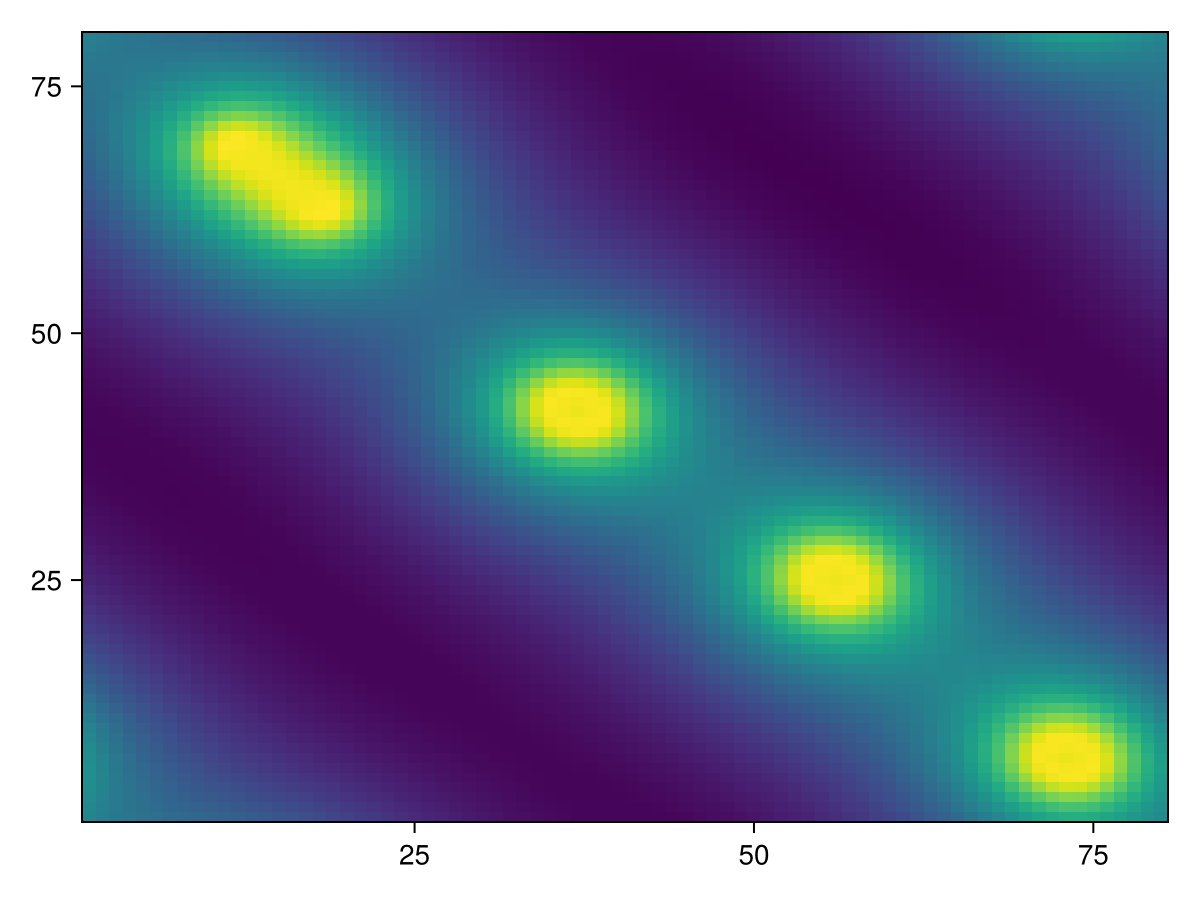

In [93]:
heatmap(sps.u[end][8,:,:])

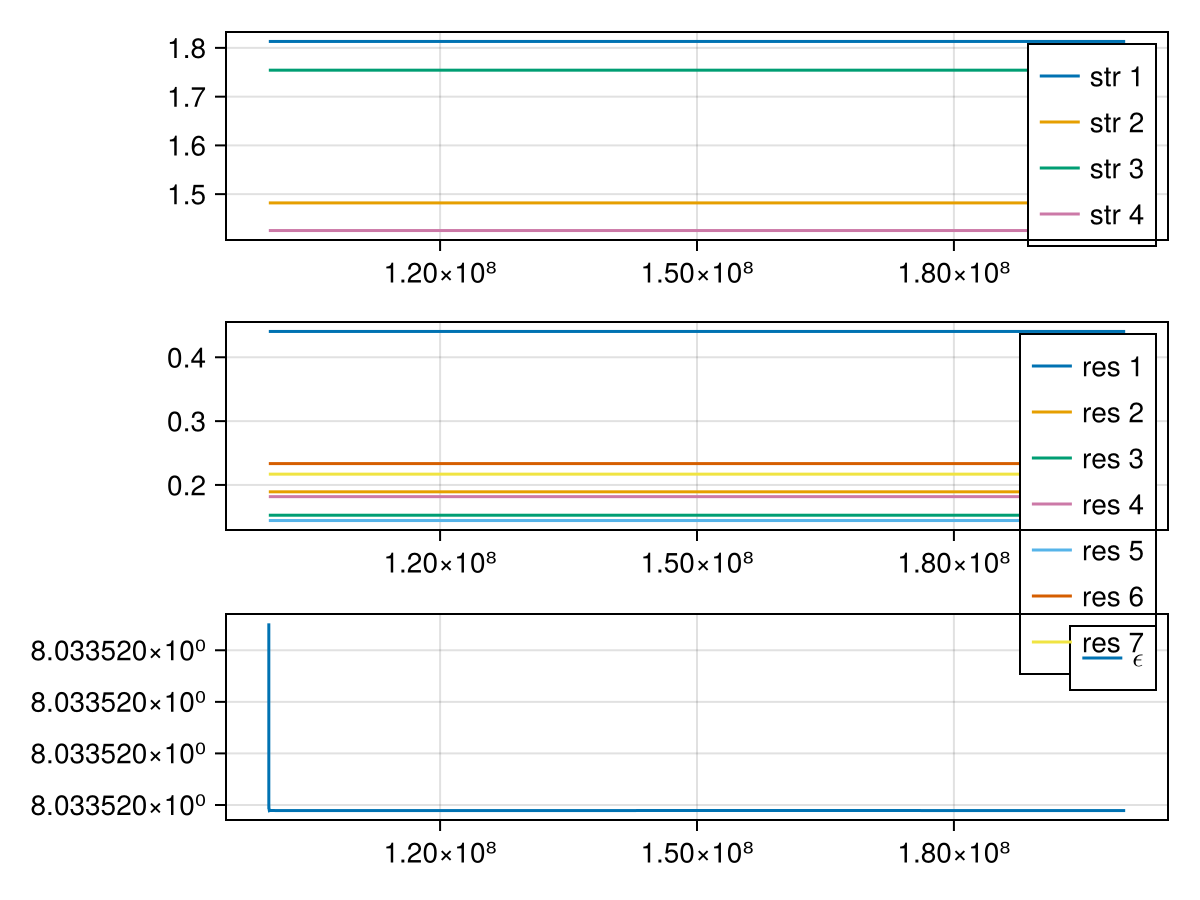

In [95]:
plot_smmicrm_sol_avgs(sps; plote=true)

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()